In [3]:
import numpy as np 
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../src")
from utils import *
from collections import Counter
import gc
import random
sns.set(rc={'figure.figsize':(15,12)})
from gensim.models import KeyedVectors, Word2Vec
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, f1_score, plot_confusion_matrix
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
from itertools import chain
import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
from torch.utils.data import DataLoader, Dataset
from textblob import Word
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer

1953

# 1.0 Exploratory Analysis

In [4]:
train_data_generator = get_lines("../data", "train.txt")
test_data_generator = get_lines("../data", "test.txt")

In [5]:
train_tags, train_tokens = get_token_tags(train_data_generator)
test_tags, test_tokens = get_token_tags(test_data_generator)

Median:19.0
Average:20.32


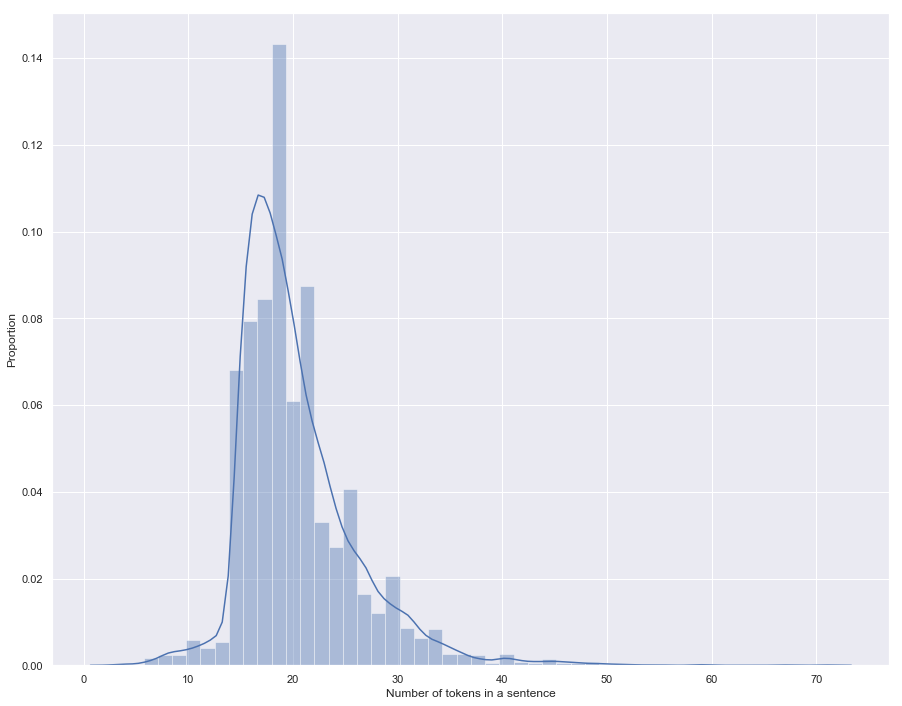

In [6]:
#Sentence length distribution
lengths = list(map(lambda x: len(x), train_data_generator))
sns.distplot(lengths)
plt.xlabel("Number of tokens in a sentence")
plt.ylabel("Proportion")
print("Median: ",np.median(lengths))
print("Average: ",round(np.mean(lengths),2))

In [7]:
def summary(item_list, limit=None):
    count_dict = dict(Counter(item_list))
    count_items = sorted(count_dict.items(), key=lambda x:x[1], reverse=True)
    print("Number of unique items: ", len(count_items))
    print("Average count: ", round(len(item_list)/len(count_items)),"\n")
    total_items = len(item_list)
    proportion_list = []
    xlabels = []
    for i, (key, value) in enumerate(count_items):
        if limit:
            if i>limit:
                break
        proportion =  round(value*100/total_items, 2)
        proportion_list.append(proportion)
        xlabels.append(key)
        # print(key, " ---> ", proportion, "%")
    sns.set(style="whitegrid")
    chart = sns.barplot(xlabels, proportion_list, orient="v")
    plt.xlabel("Tokens/Tag")
    plt.ylabel("Percentage of total Tokens/Tags")
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)


Number of unique items:25
Average count:6353



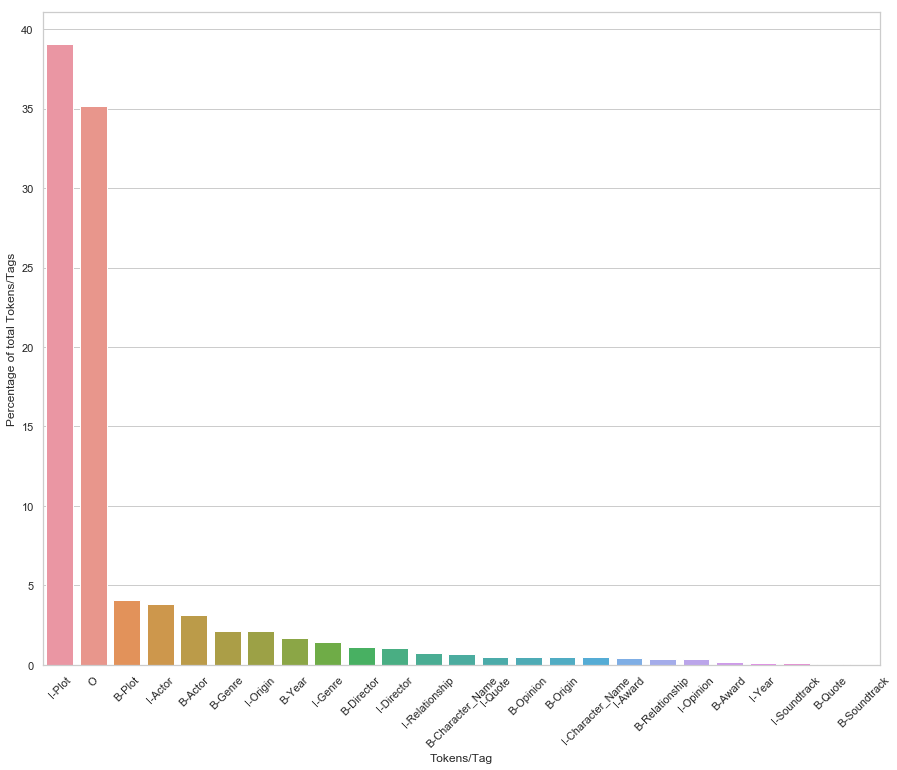

In [8]:
summary(train_tags)

In [9]:
#Number of beginnings vs Intermediate Tags
tags_counts = dict(Counter(train_tags))
beginning = 0
intermediate = 0
none = 0
for key, value in tags_counts.items():
    if key.startswith("B"):
        beginning += value
    elif key.startswith("I"):
        intermediate += value
    else:
        none += value
total = beginning + intermediate + none

print("Beginning tags proportion (B-) -> ", round(beginning*100/total,2),"%")
print("Intermediate (I-) tags proportion -> ", round(intermediate*100/total,2),"%")
print("None (O) tags proportion -> ", round(none*100/total,2),"%")

Beginning tags proportion (B-) ->14.5%
Intermediate (I-) tags proportion ->50.31%
None (O) tags proportion ->35.19%


In [10]:
#B- = beginning of an entity
#I- = intermediate/end of the entity

def average_entity_length(tags, start, end):
    '''
        Total ((#Beginnings + #Intermediate)/#Beginnings)
    '''
    tags_counter = dict(Counter(tags))
    total = tags_counter[start] + tags_counter[end]
    average = round(total/tags_counter[start], 2)
    print("Average length of " + start[2:], " is: ", average)

In [11]:
train_datasize = len(train_data_generator)
print("Average length of a sentence is: ", round(len(train_tokens)/train_datasize,2))
average_entity_length(train_tags, "B-Plot", "I-Plot")
average_entity_length(train_tags, "B-Actor", "I-Actor")
average_entity_length(train_tags, "B-Origin", "I-Origin")
average_entity_length(train_tags, "B-Director", "I-Director")
average_entity_length(train_tags, "B-Relationship", "I-Relationship")
average_entity_length(train_tags, "B-Character_Name", "I-Character_Name")
average_entity_length(train_tags, "B-Quote", "I-Quote")
average_entity_length(train_tags, "B-Opinion", "I-Opinion")
average_entity_length(train_tags, "B-Soundtrack", "I-Soundtrack")


Average length of a sentence is:20.32
Average length of Plot is:10.6
Average length of Actor is:2.22
Average length of Origin is:5.29
Average length of Director is:1.93
Average length of Relationship is:3.08
Average length of Character_Name is:1.74
Average length of Quote is:7.48
Average length of Opinion is:1.67
Average length of Soundtrack is:4.16


In [12]:
def tag_presence(data, find_tag):
    for token, tag in data:
        if tag == find_tag:
            return True
    return False

def average_starts(generator, tags, dataset_size):

    tags_counter = dict(Counter(tags))
    tags_counter = sorted(tags_counter.items(), key=lambda x:x[1], reverse=True)

    for key, value in tags_counter:
        if key.startswith("B"):
            sentence_with_tag = len(list(filter(lambda x: tag_presence(x, key), generator)))
            print("Percentage of sentences having " + key[2:], " are: ", round(sentence_with_tag*100/dataset_size,2), "%")

In [13]:
average_starts(train_data_generator, train_tags, train_datasize)

Percentage of sentences having Plot are:76.51%
Percentage of sentences having Actor are:46.4%
Percentage of sentences having Genre are:42.18%
Percentage of sentences having Year are:34.39%
Percentage of sentences having Director are:22.29%
Percentage of sentences having Character_Name are:10.39%
Percentage of sentences having Opinion are:9.8%
Percentage of sentences having Origin are:9.35%
Percentage of sentences having Relationship are:6.7%
Percentage of sentences having Award are:3.34%
Percentage of sentences having Quote are:1.54%
Percentage of sentences having Soundtrack are:0.59%


Number of unique items:10987
Average count:14



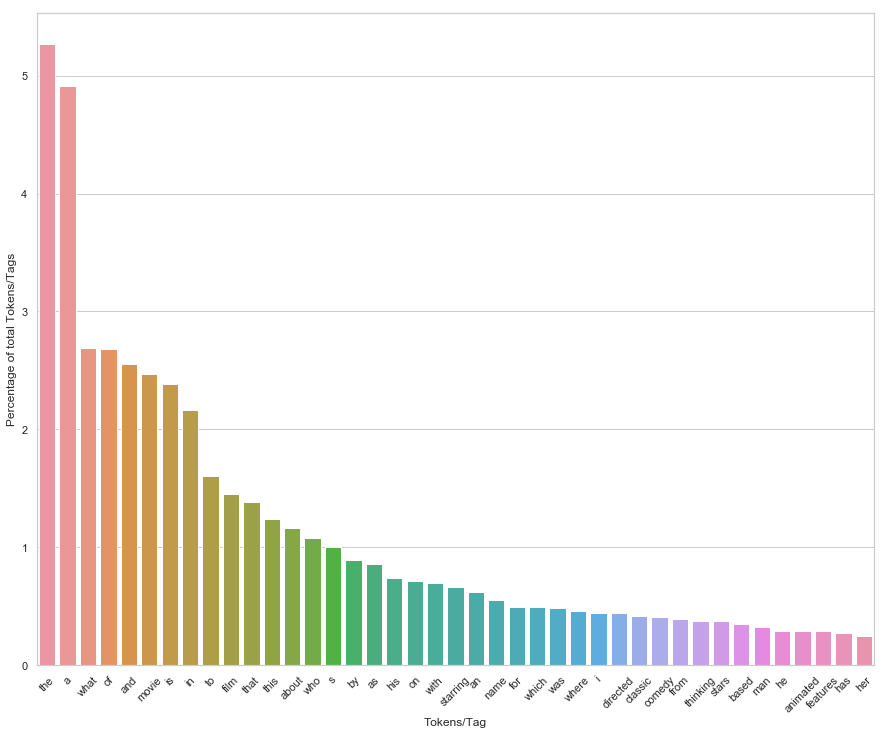

In [14]:
#Analyzing tokens
summary(train_tokens, 40)

In [15]:
def words_count(tokens, limit):
    tokens_dict = dict(Counter(tokens))
    tokens_count = tokens_dict.items()
    prop_list = []
    print("Vocabulary Size: ", len(tokens_count))
    for i in range(limit):
        tokens_filtered = len(list(filter(lambda x: x[1]<=i, tokens_count)))
        prop_list.append(round(tokens_filtered*100/len(tokens_count),2))
    plt.plot(prop_list)
    plt.xlabel("Counts")
    plt.ylabel("Proportion of Vocabulary (%)")
    # print("Proportion of unique words less than",limit,": ", round(tokens_filtered*100/len(tokens_dict),2),"%")

Vocabulary Size:10987


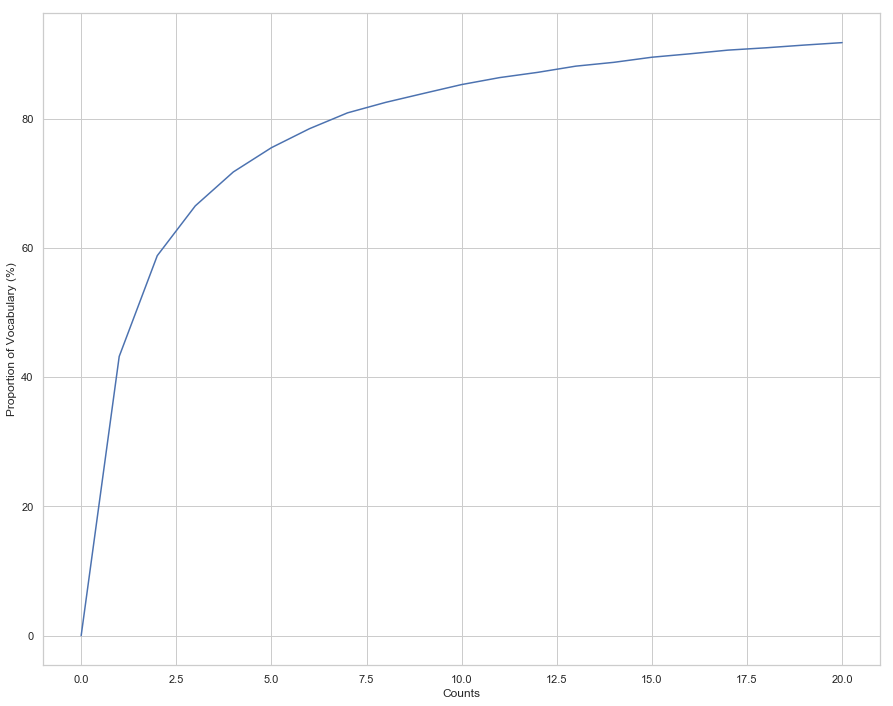

In [16]:
words_count(train_tokens, 21)

In [17]:
# numbers > <YEAR>

## 1.1 What do we know?

### 1.11 Entities
1. Our dataset it comprised of short sentences. Mostly questions describing movies.
2. Average length of a sentence is 20 tokens.
3. The raw data does not contain punctuations.
4. There are 25 classes of entities, including None (O)
5. Structurally, they are either B Tags (Beginning of an entity), I Tag (Intermediate Entity), Or None Tag (O)
6. For every I tag, there is exactly one B tag. However, more than one I tags can share a common B tag.
7. In our case, proportions of B,I,O are about 15%, 50%, 35% respectively. Meaning, our data is rich in entities. Also, most entities are multi-word.
8. Nearly 45% of entities relate to Plot (B-Plot or I-plot). There is a major class imbalance. This is followed by None Tag (~35%). Rest 22 entities comprise only 20% of the chunk. Getting these minority classes correct is a challenge.
9. Plot, Origin, Relationship, Soundtrack, Quote, Opinion are lengthy entites and almost appear in phrases. These four and None tag share common words like is,to,the,of, etc. Rest of them have propoer nouns (names).


### 1.12 Vocabulary
1. The vocabulary size is close to 11000. This is large!
2. 60% of the vocabulary has a frequency less than or equal to 2. We obviously cannot remove any vocabulary directly. We need to think of some other way to normalize words.
3. Idea - Numbers can be replaced by a common <NUM> tag. That should reduce our vocabulary substantially.
4. Since this is not 'conversational' or 'chat' text, there might not be slangs like 'Wowwww' and 'Woww'. We don't expect such modifications.
5. There are a tonne of '*'s'*'. Since punctuations are removed, they exist as single 's'. We can replace them by 'is'.
6. Similarly, 'can't' exists as ca, n, t. Three tokens. We can replace ca by can, remove single t, replace single n by not.
7. 'll' can be replaced by 'will'


# 2.0 Pre-Processing

In [18]:
def replace(sentence, to_replace, replace_by):
    for i, (token, tag) in enumerate(sentence):
        if token == to_replace:
            sentence[i] = (replace_by, tag)
    return sentence

def replace_num(sentence, replace_by = "NUM"):
    for i, (token, tag) in enumerate(sentence):
        if token.isnumeric():
            sentence[i] = (replace_by, tag)
    return sentence


def replace_nt(sentence):
    sentence = list(filter(lambda x: x[0]!="t", sentence))
    for i in range(len(sentence)):
        tag1 = sentence[i][1]
        if sentence[i][0] == "n":
            sentence[i] = ("not",tag1)
        elif sentence[i][0] == "ca":
            sentence[i] = ("can",tag1)

    return sentence

def normalize_word(word):
    stemmer = PorterStemmer()
    return stemmer.stem(word)

def normalize_sentence(sentence):
    return list(map(lambda x: (normalize_word(x[0]), x[1]), sentence))

In [19]:
def apply_preproc(data_generator):
    data_generator = list(map(lambda x: replace(x, "ca","can"), data_generator))
    data_generator = list(map(lambda x: replace(x, "s","is"), data_generator))
    data_generator = list(map(lambda x: replace(x, "ll","will"), data_generator))
    data_generator = list(map(lambda x: replace_num(x,"NUM"), data_generator))
    data_generator = list(map(lambda x: replace_nt(x), data_generator))
    data_generator = list(map(lambda x: normalize_sentence(x), data_generator))
    return data_generator

train_data_generator = apply_preproc(train_data_generator)
test_data_generator = apply_preproc(test_data_generator)

In [34]:
train_tags, train_tokens = get_token_tags(train_data_generator)
test_tags, test_tokens = get_token_tags(test_data_generator)

gc.collect()

20

In [19]:
#checks
def checks(tokens):
    assert "s" not in tokens, "'s' is still present"
    assert "t" not in tokens, "'t' is still present"
    assert "n" not in tokens, "'n' is still present"
    assert "ca" not in tokens, "'ca' is still present"
    assert "ll" not in tokens, "'ll' is still present"

checks(train_tokens)
checks(test_tokens)

# 3.0 Getting the data ready for Machine Learning

## 3.1 Approach

### Step 1: Setting up a baseline
The pipeline follows as 
Sentence Level Embeddings > Classifier > Metrics and Reports
We try different embeddings like TF-IDF, Word2Vec and use Logistic Regression


#### Approach
For a sentence with N words, consider the k'th word. We use vectors of k-3,k-2,k-1,k+1,k+2,k+3 words. In case the word doesn't exist, we use a vector of zeros


In [20]:
def stack(sentence, window=3):
    y = [x[1] for x in sentence]
    tokens = [x[0] for x in sentence]
    X = []

    for i in range(len(tokens)):
        left_pad = max(window-i,0)
        right_pad = max(window-len(tokens)+i+1,0)
        left_idx = window - left_pad
        right_idx = window - right_pad
        row = left_pad*["PAD"] + tokens[i-left_idx:i] + tokens[i+1:i+1+right_idx] + right_pad*["PAD"]
        X.append(row)
        assert len(row) == 2*window, "Length:{0}, Row:{1}, i:{2}".format(len(tokens), row, i)
    return X,y

In [21]:
train_row_data = list(map(lambda x: stack(x,3), train_data_generator))
train_rows = [item[0] for item in train_row_data]
train_labels = [item[1] for item in train_row_data]

test_row_data = list(map(lambda x: stack(x,3), test_data_generator))
test_rows = [item[0] for item in test_row_data]
test_labels = [item[1] for item in test_row_data]

In [22]:
def rows_to_2d(rows, labels):
    X = []
    y = []
    for row,label in zip(rows,labels):
        for item, tag in zip(row, label):
            X.append(item)
            y.append(tag)
    return X,y

train_X, train_y = rows_to_2d(train_rows, train_labels)
test_X, test_y = rows_to_2d(test_rows, test_labels)    

In [23]:
assert len(train_X) == len(train_y)
assert len(test_X) == len(test_y)

In [24]:
gc.collect()

60

In [25]:
word2vec = KeyedVectors.load_word2vec_format("../word2vec/GoogleNews-vectors-negative300.bin.gz", limit=10000, binary=True)

In [26]:
#

In [27]:
word2vec_vocab = list(word2vec.wv.vocab.keys())

In [28]:
common = set(word2vec_vocab).intersection(set(train_tokens))
vocab = set(train_tokens)
percent_overlap = round(len(common)*100/len(vocab), 2)
print("Common vocab (word2vec, our vocabulary): ", percent_overlap,"%")

Common vocab (word2vec, our vocabulary):21.51%


In [29]:
token_share = list(filter(lambda x: x in common, train_tokens))
common_share = round(len(token_share)*100/len(train_tokens),2)
print("The common vocabulary covers:", common_share,"% of total tokens") 

The common vocabulary covers:54.58% of total tokens


#### Observations so far
1. Pre-trained word2vec does not cover our vocabulary. This is obvious because our vocabulary contains a number of names. We don't expect the pretraind models to have all the names in the universe
2. We can move forward in one of the two options - 1) Make our own embeddings 2) Think of some workaround for the words that don't exist in the word2vec vocabulary
3. Let's brainstorm approach 2. 
    1. Another option is to replace OOV words with UNK (Unknown) token and then make embeddings
    2. Another possible workaround is to use character embeddings to build word embeddings for OOV (Out of Vocab) words.


4. For approach 1
    1. Make your own embeddings.


5. Pros and cons of approach 1.
    1. Pro - It is easy to build our own embeddings because we can cover every word in the vocabulary.
    2. Pro - We can have embeddings very specific to our movie data. Pre-trained embeddings are trained on a large dataset that doesn't necassarily relate to our data.
    3. Con - It is hard to evaluate the quality of our embeddings because they are unsupervised vectors.
    4. Con - It is a time consuming process to make our own embeddings
    5. Con - The biggest reason is, what if the test data has some new names that don't exist in our training vocabulary? This is the biggest motivation for using character level embeddings.

6. Pros and cons of approach 2.
    1. Pro - Replacing with UNK token is very easy
    2. Con - We might lose a lot of information because the model will consider nearly 35% of training tokens to be the same.
    3. Pro - character level embeddings can still preserve some information, compared to UNK token 

#### Next Steps
Try one of the options
> Use pretrained word embeddings + Custom character embeddings


# 4.0 Baseline 1 - pretrained word embeddings + custom character embeddings

In [30]:
# to train character embeddings, we take words not belonging to our word2vec vocab
char2vec = Word2Vec(vocab, size=300, sg=1, seed=42)

6914

In [31]:
def get_wordvector(token, word_model=word2vec, char_model=char2vec):
    if token in word_model.wv.vocab:
        return word_model.wv[token]
    else:
        vector = np.zeros(word_model.vector_size,)
        if token == "PAD":
            return vector
        for char in token.lower():
            vector = np.add(vector, char_model.wv[char])
        return vector

In [32]:
def row2vec(row, word_model=word2vec, char_model=char2vec):
    rowvec = [get_wordvector(token, word_model, char_model) for token in row]
    length = word_model.vector_size*len(row)
    return np.array(rowvec).reshape(length)

In [33]:
train_X = list(map(lambda x: row2vec(x), train_X))
test_X = list(map(lambda x: row2vec(x), test_X))

In [34]:
train_X = np.array(train_X).reshape(len(train_X),-1)
test_X = np.array(test_X).reshape(len(test_X),-1)

In [35]:
print(train_X.shape)
print(test_X.shape)
gc.collect()

(158726, 1800)
(39010, 1800)


80

The array is obviously very very big. We need to reduct the dimensions using some technique. We use PCA.

In [36]:
pca = PCA(n_components=100)
train_X = pca.fit_transform(train_X)
test_X = pca.transform(test_X)

In [37]:
#let's delete things we don't need

In [38]:
label2class = dict(enumerate(set(train_y)))
class2label = {value: key for key, value in label2class.items()}

In [39]:
train_y = [class2label[tag] for tag in train_y]
test_y = [class2label[tag] for tag in test_y]

In [49]:
# X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_labels, test_size=0.2, random_state=42)
classifier = RandomForestClassifier()
param_grid = {"n_estimators":[10,20,50], "max_depth":[20,30], "min_samples_leaf":[3]}

In [50]:
cv = GridSearchCV(classifier, param_grid=param_grid, n_jobs=-1, scoring="f1_macro",cv=4)
cv.fit(train_X, train_y)

GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [54]:
classifier = cv.best_estimator_
print(cv.best_params_)
print(cv.best_score_)

{'max_depth': 30, 'min_samples_leaf': 3, 'n_estimators': 20}
0.2591335664239337


In [55]:
train_predictions = classifier.predict(train_X)
test_predictions = classifier.predict(test_X)
print("Train Accuracy: ", round(100*accuracy_score(train_y, train_predictions),2))
print("Test Accuracy: ", round(100*accuracy_score(test_y, test_predictions),2))
print("Train F1: ", round(100*f1_score(train_y, train_predictions, average="macro"),2))
print("Test F1: ", round(100*f1_score(test_y, test_predictions, average="macro"),2))

Train Accuracy:90.13
Test Accuracy:68.19
Train F1:62.91
Test F1:28.2


In [56]:
def confusion_matrix_plot(true, model, X, label2class=label2class, class2label=class2label):
    true_classes = [label2class[value] for value in true]
    labels = list(label2class.values())
    plot_confusion_matrix(model, X, true, display_labels=labels, normalize='all', xticks_rotation="vertical")
    plt.xlabel("Predicted")
    plt.ylabel("True")

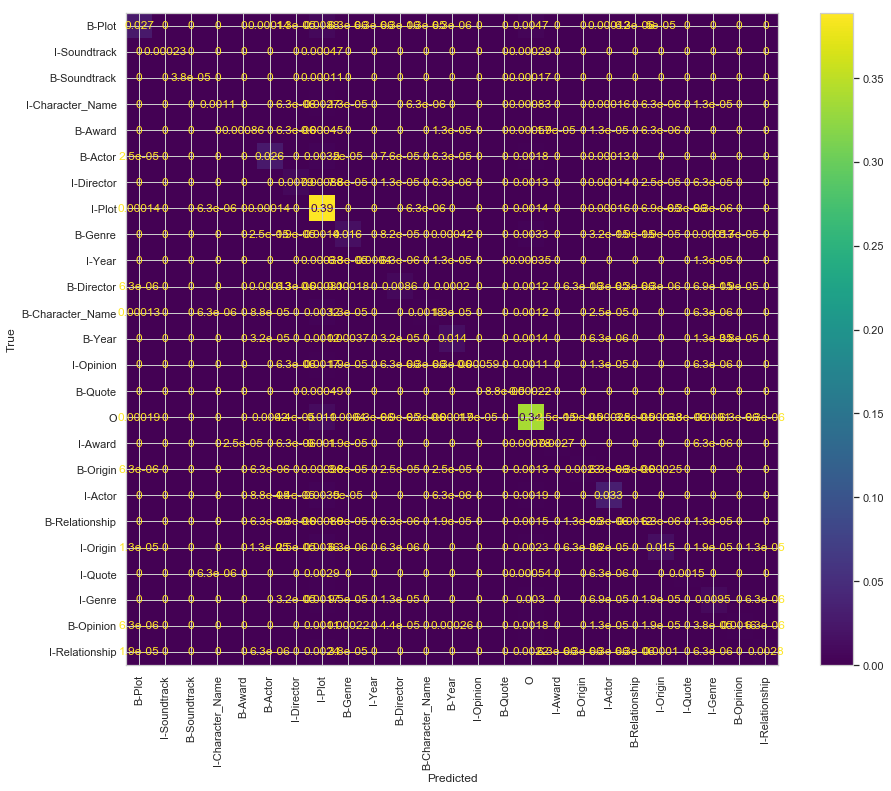

In [57]:
cm = confusion_matrix_plot(train_y, classifier, train_X)

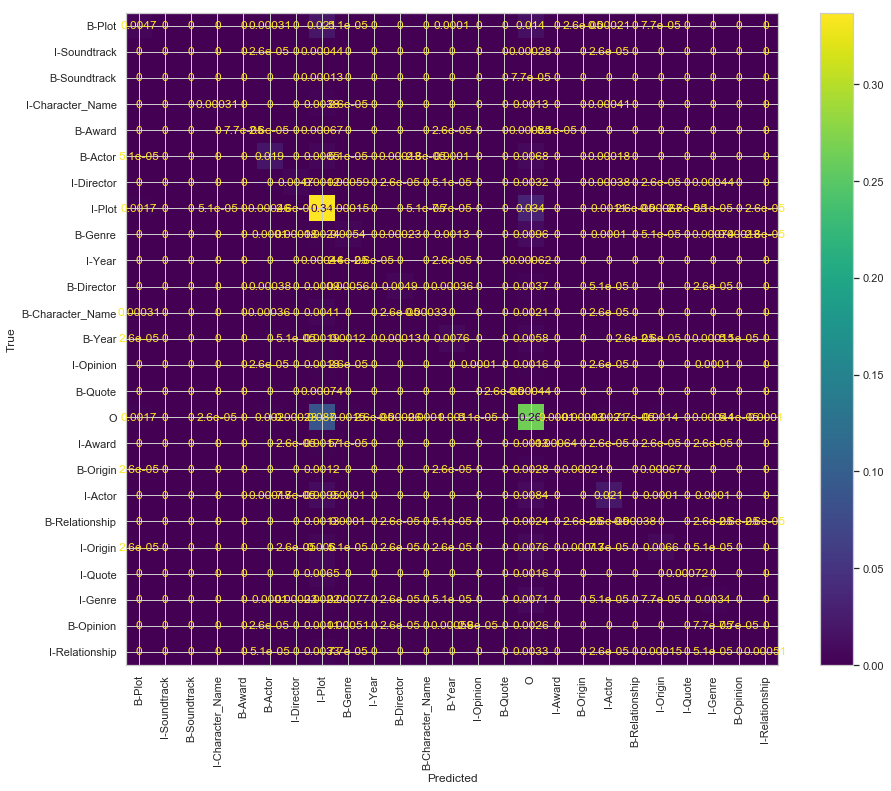

In [58]:
confusion_matrix_plot(test_y,  classifier, test_X)

In [61]:
#free up some space
del train_X, test_X
del train_y, test_y
del word2vec
del classifier

# 4.1 Analysis of Baseline

1. Overall accuracy, and the confusion matrix looks the same for both train and validation results. 
2. Although the accuracy is 70%, it is not the most representative measure of the model performance (because of the class imbalance)
3. As expected, the algorithm only learn to predict the 'I-Plot' and the 'O' tag. It barely learns to predict anything else.
4. We can try more tuning and different models, but the purpose of the baseline is to just see how good a complex model does on a simple one.



# 5.0 NER Using Deep Learning
We try to make an LSTM to predict tags. The goal is to not make a State-Of-The-Art (SOTA) model but rather understand what works and what doesn't

## 5.1 Data for deep Learning
For N sentences of a uniform length M, our data is an array of shape N*M. Since each token has a label, our labels also look like an array with same shape.

### Problem
1. Out of Vocab Words (OOV) - how do we make embeddings for words that don't occur in Vocab


### Approach
1. To solve OOV problem -
    1. Replace such words with <UNK> token. Initialize <UNK> embedding randomly
    2. Use a third-party embedding like FastText
    3. Make train your own subword embeddings and use them for such words


In [20]:
def get_data(data_generator):
    X = []
    y = []
    for pair in data_generator:
        X.append([x[0] for x in pair])
        y.append([x[1] for x in pair])
    return X,y

X_train, y_train = get_data(train_data_generator)
X_test, y_test = get_data(test_data_generator)

In [21]:
#calculating weight for class weights. These weights are used in the cross-entropy loss
count_label = dict(Counter(chain.from_iterable(y_train)))
inverse_counts = {key:1./value for key, value in count_label.items()}
sum_inverse = np.sum([count for _, count in inverse_counts.items()])
inverse_normalized =  {key:value/sum_inverse for key, value in inverse_counts.items()}
weights = np.array([0.3+inverse_normalized[idx2label[i]] for i in range(len(idx2label))])
weights /= np.sum(weights)

In [24]:
#checks
def check2(X,y):
    for _x, _y in zip(X,y):
        assert len(_x) == len(_y)
    
check2(X_train, y_train)
check2(X_test, y_test)

In [25]:
#from our analysis previously, we take all the sentences with length 40 or below. For the ones less than 40, we pad. For the rest, we trim
MAX_LEN=40

def trim(X, y, max_len=MAX_LEN):
    sequence = []
    for i in range(len(X)):
        if len(X[i])>=max_len:
            X[i] = X[i][:max_len]
            y[i] = y[i][:max_len]
            sequence.append(max_len)
        else:
            sequence.append(len(X[i]))
    return X, y, sequence

In [26]:
X_train, y_train, train_seq = trim(X_train, y_train, MAX_LEN)
X_test, y_test, test_seq = trim(X_test, y_test, MAX_LEN)

In [27]:
#checks
def check3(X, y, sequence):
    assert len(X) == len(y)
    assert len(X) == len(sequence)
    for seq, tags in zip(X,y):
        assert len(tags) <= MAX_LEN
        assert len(seq) == len(tags)

check3(X_train, y_train, train_seq)
check3(X_test, y_test, test_seq)

In [28]:
PADDING_TOKEN = "PAD"
UNKNOWN_TOKEN = "UNK"

inverse_normalized[PADDING_TOKEN] =0

def replace_by_counts(tokens, max_count, replace_by):
    '''
        Replaces tokens with count<=max_counts by the token 'replace_by'
    '''
    counts = dict(Counter(tokens)).items()
    vocab = [token if count>max_count else replace_by for token, count in counts]
    return list(set(vocab))

In [29]:
#


4518

In [30]:
#create a vocab to unique idx mapping and vice-versa

tokens = list(chain.from_iterable(X_train))
vocab = replace_by_counts(tokens, 4, UNKNOWN_TOKEN)
vocab.append(PADDING_TOKEN)
idx2word = dict(enumerate(set(vocab)))
word2idx = {value: key for key, value in idx2word.items()}

labels = list(chain.from_iterable(y_train))
labels.append(PADDING_TOKEN)
idx2label = dict(enumerate(set(labels)))
label2idx = {value: key for key, value in idx2label.items()}


In [31]:
#replace tokens by their indices from the dictionary. Same for labels

def unk_map(x, token2idx, unk):
    '''
    Replace tokens by unk token idx if they are not in the vocabulary
    '''
    idx = []
    for word in x:
        if word not in token2idx.keys():
            idx.append(unk)
        else:
            idx.append(token2idx[word])
    return idx

unk_idx = word2idx["UNK"]

X_train = list(map(lambda x: unk_map(x, word2idx, unk_idx), X_train))
y_train = list(map(lambda x: [label2idx[word] for word in x], y_train))

X_test = list(map(lambda x: unk_map(x, word2idx, unk_idx), X_test))
y_test = list(map(lambda x: [label2idx[word] for word in x], y_test))

In [32]:
#creating pytorch dataset for iteration and generating batches
class NERDataset(Dataset):
    def __init__(self, X, y, sequence):
        self.X = X
        self.y = y
        self.seq = sequence
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.seq[idx]

def pad(X, Y, seq, pad_idx, pad_label, max_len):
    '''
    add pad_idx to tokens and pad_label to labels is correspinding PAD tokens
    '''
    X_padd = []
    y_padd = []
    for x,y in zip(X,Y):
        x_len = max_len - len(x)
        X_padd.append(x+[pad_idx]*x_len)
        y_padd.append(y + [pad_label]*x_len)
    X_padd = torch.LongTensor(X_padd)
    y_padd = torch.LongTensor(y_padd)
    seq = torch.LongTensor(seq)
    return X_padd, y_padd, seq

X_train, y_train, train_seq = pad(X_train, y_train, train_seq, word2idx["PAD"], label2idx["PAD"], MAX_LEN)

In [33]:
X_test, y_test, test_seq = pad(X_test, y_test, test_seq, word2idx["PAD"], label2idx["PAD"], MAX_LEN)

In [35]:
train_dataset = NERDataset(X_train, y_train, train_seq)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = NERDataset(X_test, y_test, test_seq)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

torch.Size([1953, 40])

In [36]:
gc.collect()

40

Now our data is ready for deep learning

## 5.2 Model Building - LSTM

In [37]:
class NERLstm(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, padding_idx, max_len, num_layers):
        super(NERLstm, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.linear = nn.Linear(2*hidden_dim, tagset_size)
        self.padding_idx = padding_idx
        self.max_len = max_len 
        self.tagset_size = tagset_size
        self.padding_idx = padding_idx


    def forward(self, X, seq):
        embeddings = self.word_embeddings(X)
        packed_input = pack_padded_sequence(embeddings, seq, batch_first=True, enforce_sorted=False)
        packed_output, (ht,ct) = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = self.linear(output)
        return output

In [38]:
config = {
    'embedding_dim': 128,
    'hidden_dim': 1024,
    'vocab_size': 100,
    'tagset_size': len(idx2label),
    'padding_idx': 0,
    'max_len': 3,
    "num_layers":2
}


In [39]:
#test
def test_model():
    '''
    Testing the model
    '''
    test_model = NERLstm(**config)
    test_X = torch.LongTensor([[1,5,3], [4,0,0]])
    test_y = torch.LongTensor([[1,2,3], [4,5,5]])
    test_sequence = torch.LongTensor([3,1])
    test_output = test_model(test_X,test_sequence)
    print(test_output.shape)

In [40]:
test_model()

torch.Size([2, 3, 26])


In [84]:
        
def loss(true, pred, pad_idx, target_size, max_len, weights=None, device="cpu"):
    '''
        Calculate loss without taking PAD loss into account
    '''
    batch_size = pred.shape[0]
    max_batch = pred.shape[1]
    weights = torch.Tensor(weights)
    weights = weights.to(device)
    loss_fn = nn.CrossEntropyLoss(reduction='none', weight=weights)
    pred = pred[:,:max_batch,:]
    true = true[:,:max_batch].contiguous()
    true = true.view(-1)
    pred = pred.view(-1, target_size)
    loss = loss_fn(pred, true)
    mask = true != pad_idx
    mask = mask.view(-1).type(torch.FloatTensor).to(device)
    mask /= mask.shape[0]
    return torch.dot(mask, loss)/torch.sum(mask)

def generate_predictions(model, X, seq, device="cuda"):
    X = X.to(device)
    seq = seq.to(device)
    pred = model(X, seq)
    pred_labels = torch.argmax(pred, 2)
    pred_labels = pred_labels.view(-1)
    return pred_labels


def accuracy(model, X, seq, y_true, pad_idx, device):
    y_true = y_true.view(-1)
    y_pred = generate_predictions(model, X, seq, device)
    mask = y_true!=pad_idx
    mask = mask.type(torch.FloatTensor)
    matches = y_pred == y_true
    matches = matches.type(torch.FloatTensor)
    correct = torch.dot(matches, mask)
    total = len(y_pred)
    accuracy = correct.item()/total
    return accuracy

In [85]:
#testing masked loss
# loss(test_y, test_output, word2idx["PAD"], config["tagset_size"], config["max_len"])

## 5.3 Training Loop

In [129]:

EMBEDDING_DIM = 300
HIDDEN_DIM = 512
VOCAB_SIZE = len(word2idx)
TAGSET_SIZE = len(idx2label)
BATCH_SIZE = 128
LEARNING_RATE = 10e-3
EPOCHS = 22
NUM_LAYERS=3

config = {
    'embedding_dim': EMBEDDING_DIM ,
    'hidden_dim': HIDDEN_DIM,
    'vocab_size': VOCAB_SIZE,
    'tagset_size': TAGSET_SIZE,
    'padding_idx': word2idx["PAD"],
    'max_len': MAX_LEN,
    'num_layers': NUM_LAYERS
}


In [130]:
if torch.cuda.is_available:
    device = "cuda"
else:
    device = "cpu"

In [131]:
model = NERLstm(**config)
model = model.to(device)

In [132]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [133]:
train_loss = []
test_loss = []
test_accuracy = []
train_accuracy = []


In [134]:

for i in range(EPOCHS):  
    epoch_loss = 0
    model = model.train()
    LEARNING_RATE *= 0.8
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    for j, (X,y,sequence) in enumerate(train_loader):
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        # print(X.shape, y.shape, sequence.shape)
        sequence = sequence.to(device)
        pred = model(X, sequence)
        loss_value = loss(y, pred, config['padding_idx'],config['tagset_size'],config["max_len"],weights=weights, device=device)
        loss_value.backward()
        # print(j ,": ",round(loss_value.item(),2))
        epoch_loss += loss_value.item()
        optimizer.step()
        del X,y,sequence
        torch.cuda.empty_cache()
    

  
    model = model.eval()

    train_loss.append(round(epoch_loss,3))

    X_test = X_test.to(device)
    y_test = y_test.to(device)
    test_seq = test_seq.to(device)

    y_pred = model(X_test, test_seq)
    test_epoch_loss = loss(y_test, y_pred, config['padding_idx'],config['tagset_size'],config["max_len"], weights, device)
    test_epoch_loss = round(test_epoch_loss.item(),3)
    test_loss.append(test_epoch_loss)
    
    test_epoch_acc = round(accuracy(model, X_test, test_seq, y_test, config["padding_idx"], device),3)
    test_accuracy.append(test_epoch_acc)
    
    print("-----------Epoch: {}-----------".format(i+1))
    print("Loss:\ntrain:{0}\ntest:{1}\n".format(round(epoch_loss,2), test_epoch_loss))    
    print("Accuracy:\ntest:{0}\n".format(test_epoch_acc))

  

-----------Epoch: 1-----------
Loss:
train:9.35
test:0.02

Accuracy:
test:0.923

-----------Epoch: 2-----------
Loss:
train:2.94
test:0.01

Accuracy:
test:0.926

-----------Epoch: 3-----------
Loss:
train:1.47
test:0.009

Accuracy:
test:0.926

-----------Epoch: 4-----------
Loss:
train:0.86
test:0.01

Accuracy:
test:0.926

-----------Epoch: 5-----------
Loss:
train:0.48
test:0.011

Accuracy:
test:0.926

-----------Epoch: 6-----------
Loss:
train:0.24
test:0.013

Accuracy:
test:0.925

-----------Epoch: 7-----------
Loss:
train:0.12
test:0.014

Accuracy:
test:0.925

-----------Epoch: 8-----------
Loss:
train:0.06
test:0.015

Accuracy:
test:0.925

-----------Epoch: 9-----------
Loss:
train:0.03
test:0.016

Accuracy:
test:0.926



KeyboardInterrupt: 

In [ ]:
plt.plot(test_accuracy)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

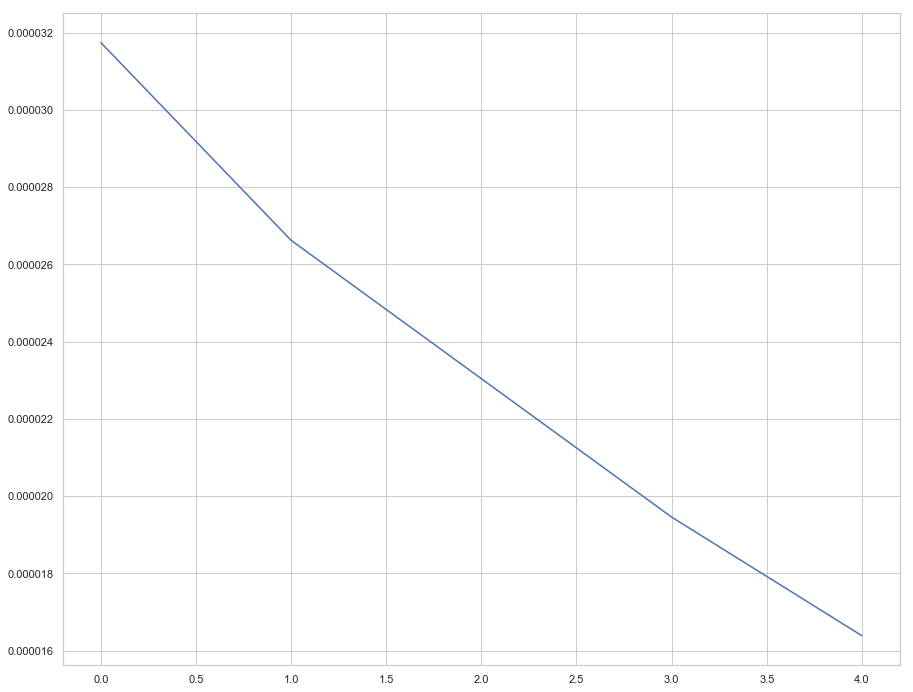

In [78]:
plt.plot(np.array(test_loss)/len(X_test))
# X,y,sequence = next(iter(train_loader))

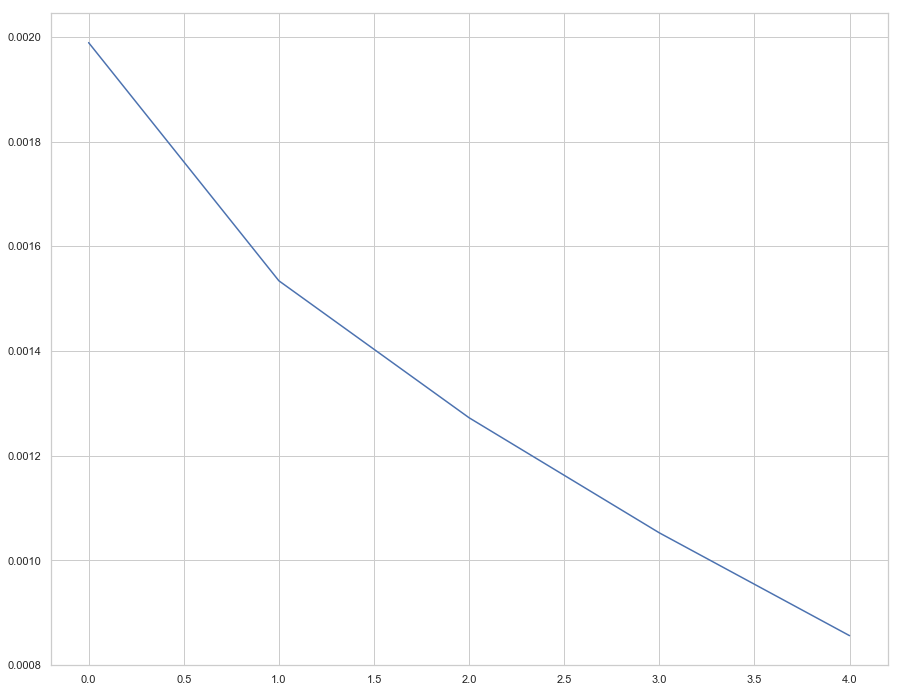

In [79]:
plt.plot(np.array(train_loss)/len(X_train))

In [101]:
def F1_scores(y_true, y_pred, idx, pad_idx):
    y_pred = torch.argmax(y_pred, 2)
    y_true = y_true.to("cpu").type(torch.LongTensor).numpy().reshape(-1)
    y_pred = y_pred.to("cpu").type(torch.LongTensor).numpy().reshape(-1)

    tp = 0
    tn = 0
    fp = 0
    fn = 0
    p = 0
    n = 0
    for i, true in enumerate(y_true):
        if true!=pad_idx:
            pred = y_pred[i]
            if true == idx:
                p+=1
                if pred == idx:
                    tp+=1
                else:
                    fn+=1
            else:
                n+=1
                if pred == idx:
                    fp+=1
                else:
                    tn+=1
    
    precision = tp/(tp+fp+0.0001)
    recall = tp/(tp+fn+0.0001)
    f1 = 2*precision*recall/(precision+recall+0.0001)

    return round(f1,3), round(precision,3), round(recall,3)

In [102]:
total = 0
for tag, idx in label2idx.items():
    f1, prec, rec = F1_scores(y_test, y_pred, label2idx[tag], label2idx["PAD"])
    print(tag+" stats: "+"precision: ",prec," recall: ",rec, " F1: ",f1)
    total += f1
print("------ Average: {} ------".format(total/len(label2idx)))

I-Opinion stats: precision:0.358 recall:0.168 F1:0.229
I-Year stats: precision:0.816 recall:0.705 F1:0.756
B-Soundtrack stats: precision:1.0 recall:0.25 F1:0.4
B-Plot stats: precision:0.486 recall:0.437 F1:0.46
I-Award stats: precision:0.714 recall:0.748 F1:0.731
I-Director stats: precision:0.895 recall:0.92 F1:0.907
I-Soundtrack stats: precision:0.583 recall:0.233 F1:0.333
B-Actor stats: precision:0.923 recall:0.935 F1:0.929
B-Character_Name stats: precision:0.636 recall:0.58 F1:0.606
I-Character_Name stats: precision:0.716 recall:0.621 F1:0.665
B-Quote stats: precision:0.833 recall:0.426 F1:0.563
I-Origin stats: precision:0.665 recall:0.693 F1:0.679
I-Relationship stats: precision:0.594 recall:0.46 F1:0.518
I-Genre stats: precision:0.759 recall:0.751 F1:0.755
PAD stats: precision:0.0 recall:0.0 F1:0.0
O stats: precision:0.868 recall:0.857 F1:0.862
B-Director stats: precision:0.836 recall:0.899 F1:0.866
B-Award stats: precision:0.746 recall:0.677 F1:0.71
B-Opinion stats: precision:0.4

In [103]:
#analysis
def analyze(y_pred, y_true, X_test):
    y_pred = torch.argmax(y_pred, 2)
    y_true = y_true.to("cpu").type(torch.LongTensor).numpy().reshape(-1)
    y_pred = y_pred.to("cpu").type(torch.LongTensor).numpy().reshape(-1)
    X_test = X_test.to("cpu").type(torch.LongTensor).numpy().reshape(-1)
    where_incorrect = y_true != y_pred
    incorrect_idxes = np.where(where_incorrect==1)[0]
    incorrect_tokens = X_test[incorrect_idxes]
    return dict(Counter(incorrect_tokens))

In [105]:
incorrect_dict = analyze(y_pred, y_test, X_test)
incorrect_dict = sorted(incorrect_dict.items(), key=lambda x:x[1], reverse=True)
for idx, count in incorrect_dict[:20]:
    print(idx2word[idx], " ----> ", count)

UNK ---->654
a ---->489
the ---->344
of ---->172
and ---->126
about ---->110
is ---->110
classic ---->93
in ---->91
film ---->76
on ---->75
movi ---->68
base ---->63
an ---->60
stori ---->59
to ---->56
num ---->50
as ---->38
by ---->37
with ---->35


In [106]:
def predict_tags(sentence, model=model, word2idx=word2idx, 
                idx2word=idx2word, label2idx=label2idx, idx2label=idx2label):
    tokens = sentence.lower().split()
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    length = len(tokens)
    tokens_idx = []
    for token in stemmed_tokens:
        if token not in word2idx.keys():
            tokens_idx.append(word2idx["UNK"])
        else:
            tokens_idx.append(word2idx[token])
    
    tokens_idx = torch.LongTensor(tokens_idx).unsqueeze(0)
    sequence = torch.LongTensor([length])
    predictions = generate_predictions(model, tokens_idx, sequence)
    for token, label in zip(tokens, predictions):
        print(token," ----> ", idx2label[label.item()])

In [119]:
predict_tags("Swades starring shahrukh khan describes the state of rural india very well")

swades ---->O
starring ---->O
shahrukh ---->B-Actor
khan ---->I-Actor
describes ---->B-Plot
the ---->I-Plot
state ---->I-Plot
of ---->I-Plot
rural ---->I-Plot
india ---->I-Plot
very ---->I-Plot
well ---->I-Plot


In [120]:
predict_tags("Amir khan plays mahavir phogat in the real life based film dangal")

amir ---->B-Actor
khan ---->I-Actor
plays ---->O
mahavir ---->B-Character_Name
phogat ---->I-Character_Name
in ---->O
the ---->O
real ---->O
life ---->O
based ---->O
film ---->O
dangal ---->O


In [121]:
predict_tags("sholay is said to be one of the greates film of its time")

sholay ---->O
is ---->O
said ---->O
to ---->O
be ---->I-Opinion
one ---->I-Opinion
of ---->I-Opinion
the ---->I-Opinion
greates ---->I-Opinion
film ---->O
of ---->O
its ---->O
time ---->O
